## Prerequisites

- Download political dataset from GitHub repository.
- Install Hugging Face transformers library.
- Import modules used in the code.

In [401]:
!git clone -q https://github.com/acmucsd-projects/fa22-ai-team-2
!pip install -q transformers

In [384]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from transformers import get_linear_schedule_with_warmup

## Loading Dataset

In [402]:
path = 'fa22-ai-team-2/data.csv'

In [403]:
def load_dataset(csv_path) :

  df = pd.read_csv(csv_path)

  cols = ['Title', 'Political Lean', 'Text']
  title, political_lean, text = map(df.get, cols)

  texts, remove_newline = [], lambda T: T.replace('\n', '')
  for i in df.index :
    if type(text[i]) == float :
      new_text = remove_newline(title[i])
    else :
      new_text = ' '.join(map(remove_newline, (title[i], text[i])))
    texts.append(new_text)

  labels = political_lean.replace(['Liberal', 'Conservative'], [0, 1])

  return pd.DataFrame({'label': labels, 'text': texts})

In [404]:
df = load_dataset(path)

## Variable Configuration

In [ ]:
pretrained_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
bert_model = BertModel.from_pretrained(pretrained_model_name)

In [340]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_classes = 2
maximum_word_length = 50
random_seed = 42
batch_size = 8
num_epochs = 4

## Generate DataLoader

In [341]:
class RedditDataset(Dataset) :

  def __init__(self, texts, labels, tokenizer, max_len) :
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self) :
    return len(self.texts)

  def __getitem__(self, item) :
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text, max_length=self.max_len,
      padding='max_length',
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt'
    )

    return {
      'text': text, 
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

In [342]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.3,
    random_state=random_seed
)

df_valid, df_test = train_test_split(
    df_test, 
    test_size=0.4,
    random_state=random_seed
)

In [343]:
def create_dataloader(df, tokenizer, max_len, batch_size) :

  dataset = RedditDataset(
    texts = df.text.to_numpy(),
    labels = df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size
  )

train_dataloader = create_dataloader(df_train, tokenizer, maximum_word_length, batch_size)
valid_dataloader = create_dataloader(df_valid, tokenizer, maximum_word_length, batch_size)
test_dataloader  = create_dataloader(df_test,  tokenizer, maximum_word_length, batch_size)

## Sentiment Classification Model Using BERT

In [344]:
class SentimentClassifier(nn.Module) :

  def __init__(self, n_classes) :

    super(SentimentClassifier, self).__init__()
    
    self.BERT = BertModel.from_pretrained(pretrained_model_name)
    self.dropout = nn.Dropout(p=0.3)
    self.fc = nn.Linear(self.BERT.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask) :
    _, pooled_output = self.BERT(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.dropout(pooled_output)
    return self.fc(output)

In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

## Model Training Tools

In [346]:
optim = torch.optim.RAdam(model.parameters(), lr=5e-5, weight_decay=1e-4)

loss_fn = nn.BCEWithLogitsLoss().to(device)

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [347]:
def train_epoch(model, dataloader, optim, loss_fn, device, scheduler, n_examples) :

  model = model.train()

  iter, threshold = 0, 0.1
  losses = []
  correct_pred = 0

  for d in dataloader :

    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)

    labels = d['label'].to(device)
    encoded_labels = torch.eye(2)[d['label']].to(device)

    outputs = model(input_ids=input_ids,
                  attention_mask=attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, encoded_labels)

    correct_pred += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optim.step()
    scheduler.step()
    optim.zero_grad()

    if iter > threshold * len(dataloader) :
      print(f'Iteration {iter}/{len(dataloader)}')
      threshold += 0.1
    iter += 1

  return correct_pred.double() / n_examples, np.mean(losses)

In [348]:
def eval_epoch(model, dataloader, loss_fn, device, n_examples) :

  model = model.eval()

  losses = []
  correct_pred = 0
  history = []

  with torch.no_grad() :

    for d in dataloader :

      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)

      labels = d['label'].to(device)
      encoded_labels = torch.eye(2)[d['label']].to(device)

      outputs = model(input_ids=input_ids, 
                      attention_mask=attention_mask)
      
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, encoded_labels)

      correct_pred += torch.sum(preds == labels)
      losses.append(loss.item())
      history.append((preds, labels))
  
  return correct_pred.double() / n_examples, np.mean(losses), history

## Model Training

In [349]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(num_epochs) :

  print(f'Epoch {epoch+1}/{num_epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model, train_dataloader, optim, loss_fn,
      device, scheduler, len(df_train)
  )

  print(f'Train Loss: {train_loss:.3f}\tAccuracy: {train_acc:.3f}')

  valid_acc, valid_loss, _ = eval_epoch(
      model, valid_dataloader, loss_fn,
      device, len(df_valid)
  )

  print(f'Valid Loss: {valid_loss:.3f}\tAccuracy: {valid_acc:.3f}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['valid_acc'].append(valid_acc)
  history['valid_loss'].append(valid_loss)

Epoch 1/4
----------
Iteration 113/1125
Iteration 226/1125
Iteration 338/1125
Iteration 451/1125
Iteration 563/1125
Iteration 676/1125
Iteration 788/1125
Iteration 900/1125
Iteration 1013/1125
Train Loss: 0.585	Accuracy: 0.702
Valid Loss: 0.541	Accuracy: 0.757

Epoch 2/4
----------
Iteration 113/1125
Iteration 226/1125
Iteration 338/1125
Iteration 451/1125
Iteration 563/1125
Iteration 676/1125
Iteration 788/1125
Iteration 900/1125
Iteration 1013/1125
Train Loss: 0.457	Accuracy: 0.810
Valid Loss: 0.795	Accuracy: 0.761

Epoch 3/4
----------
Iteration 113/1125
Iteration 226/1125
Iteration 338/1125
Iteration 451/1125
Iteration 563/1125
Iteration 676/1125
Iteration 788/1125
Iteration 900/1125
Iteration 1013/1125
Train Loss: 0.338	Accuracy: 0.887
Valid Loss: 0.958	Accuracy: 0.770

Epoch 4/4
----------
Iteration 113/1125
Iteration 226/1125
Iteration 338/1125
Iteration 451/1125
Iteration 563/1125
Iteration 676/1125
Iteration 788/1125
Iteration 900/1125
Iteration 1013/1125
Train Loss: 0.228	Acc

## Calculate Testing Accuracy of the Model

In [350]:
test_acc, _, acc = eval_epoch(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7990926766040182

## Result Visualizations

In [366]:
hist2val = lambda hist: [float(t) for t in hist]

Text(0.5, 0, 'Epochs')

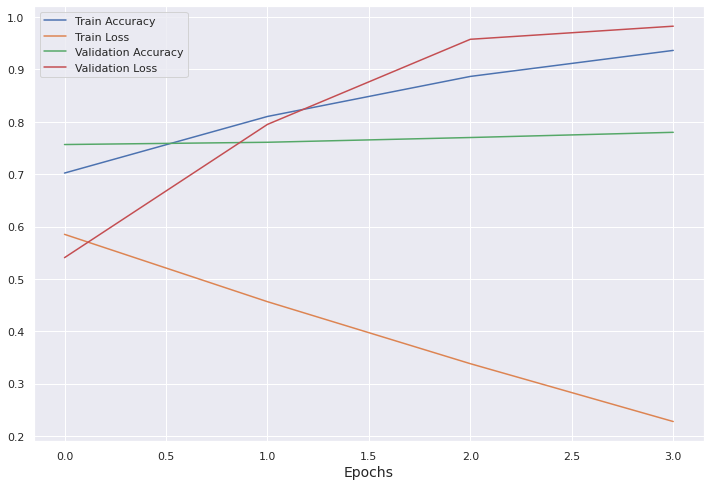

In [386]:
for hist in history.values() :
  sns.lineplot(x=range(num_epochs), y=hist2val(hist))

rcParams['figure.figsize'] = 12, 8
plt.legend(['Train Accuracy', 'Train Loss',
            'Validation Accuracy', 'Validation Loss'])
plt.xlabel('Epochs', fontsize=14)

In [351]:
val_00, val_01, val_10, val_11 = 0, 0, 0, 0

for step in acc :
  for (i, z) in zip(*step) :
    i, z = int(i), int(z)
    if i == z :
      if i == 0 :
        val_00 += 1
      else :
        val_11 += 1
    else :
      if i == 0 :
        val_01 += 1
      else :
        val_10 += 1

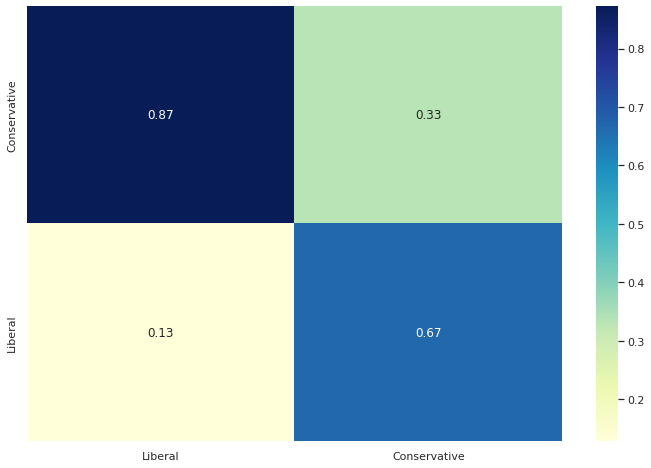

In [396]:
res = np.array([[val_00, val_01],
                [val_10, val_11]])

sns.heatmap(res/sum(res), annot=True, cmap='YlGnBu',
            xticklabels=['Liberal', 'Conservative'],
            yticklabels=['Conservative', 'Liberal'])